# 고객세분화

# 데이터
## import

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 15})

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA 

## 데이터 읽기

In [44]:
!curl https://raw.githubusercontent.com/ShubhankarRawat/Mall-Customers-Segmentation/master/data.csv\
    -o customer.csv
data = pd.read_csv('customer.csv')
print(data.shape)
data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3780  100  3780    0     0  99473      0 --:--:-- --:--:-- --:--:-- 99473
(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [45]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 전처리
- 성별을 One Hot Encoding 

In [46]:
data = pd.get_dummies(data, columns = ['Gender'])
data[:5]

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,0,1
1,2,21,15,81,0,1
2,3,20,16,6,1,0
3,4,23,16,77,1,0
4,5,31,17,40,1,0


## 스케일링

In [47]:
scaler = StandardScaler()
df = data.copy()
continuous = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df[continuous] = scaler.fit_transform(df[continuous])
df = df.drop("CustomerID", axis=1)
df[:5]

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,-1.424569,-1.738999,-0.434801,0,1
1,-1.281035,-1.738999,1.195704,0,1
2,-1.352802,-1.700830,-1.715913,1,0
3,-1.137502,-1.700830,1.040418,1,0
4,-0.563369,-1.662660,-0.395980,1,0


# 최적의 클러스터 수 찾기

- 덴드로그램
- 실루엣 지수 보기
- mass(inertia)의 변화 보기

## 덴드로그램

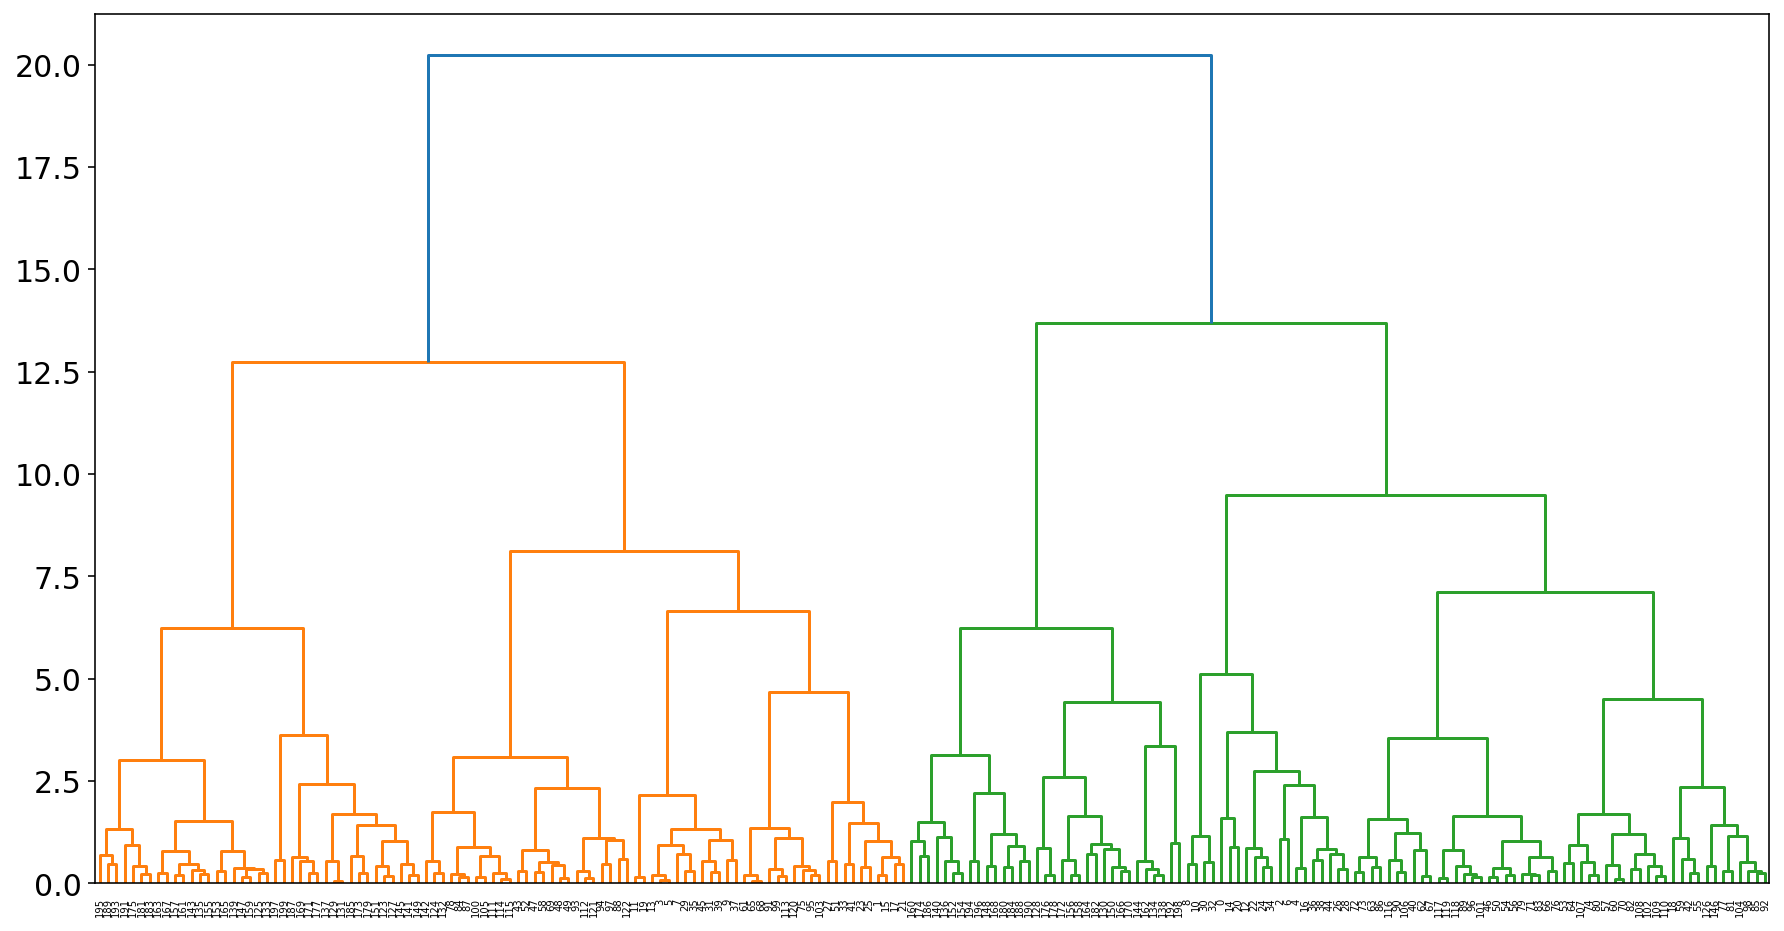

In [48]:
plt.figure(figsize=(15, 8))
link_dist = linkage(df, metric='euclidean', method='ward')  
dendrogram(link_dist, labels=df.index.tolist())
plt.show()

## 실루엣 지수

In [49]:
results = []
for i in range(2,12):
  cluster_labels = KMeans(n_clusters=i).fit_predict(df)
  score = silhouette_score(df, cluster_labels)
  results.append([i,score])

df_result = pd.DataFrame(results, columns=["n_clusters","silhouette_score"])
df_result.set_index('n_clusters', inplace=True)
df_result

,silhouette_score
n_clusters,
2,0.282065
3,0.286824
4,0.319470
5,0.307407
6,0.305835
7,0.315825
8,0.330779
9,0.344737
10,0.358039


## knee 포인트

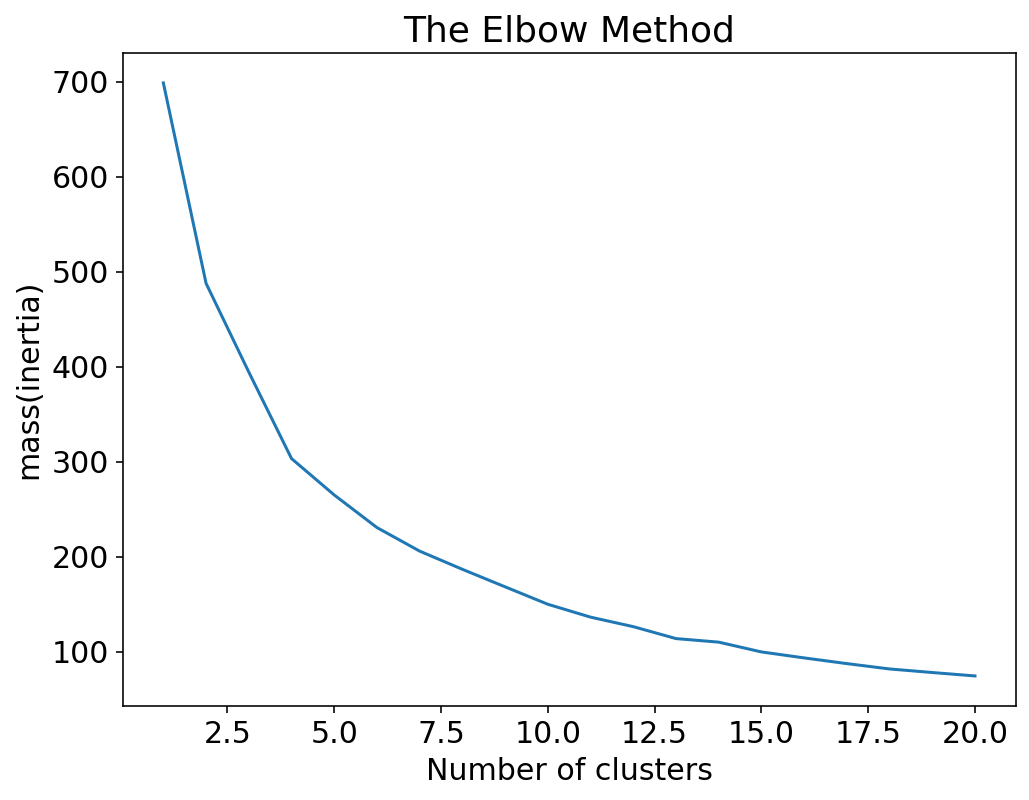

In [50]:
# elbow 포인트, knee 포인트
mass = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(df)
    mass.append(kmeans.inertia_)
plt.plot(range(1, 21), mass)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('mass(inertia)')
plt.show()

# 결과 보기
- 클러스터 수 k=5 선택

In [51]:
kmeans = KMeans(n_clusters = 5)
y_kmeans = kmeans.fit_predict(df)

## 개인별 클러스터 번호 보기

In [53]:
data2 = data.copy()
data2["Cluster"] = y_kmeans
data2

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,Cluster
0,1,19,15,39,0,1,0
1,2,21,15,81,0,1,0
2,3,20,16,6,1,0,1
3,4,23,16,77,1,0,0
4,5,31,17,40,1,0,1
...,...,...,...,...,...,...,...
195,196,35,120,79,1,0,2
196,197,45,126,28,1,0,4
197,198,32,126,74,0,1,2
198,199,32,137,18,0,1,4


## PCA(2) 축에서 그리기

- PCA 개념

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-10-04%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%209.24.09.png?raw=1" align='left'  width=300>

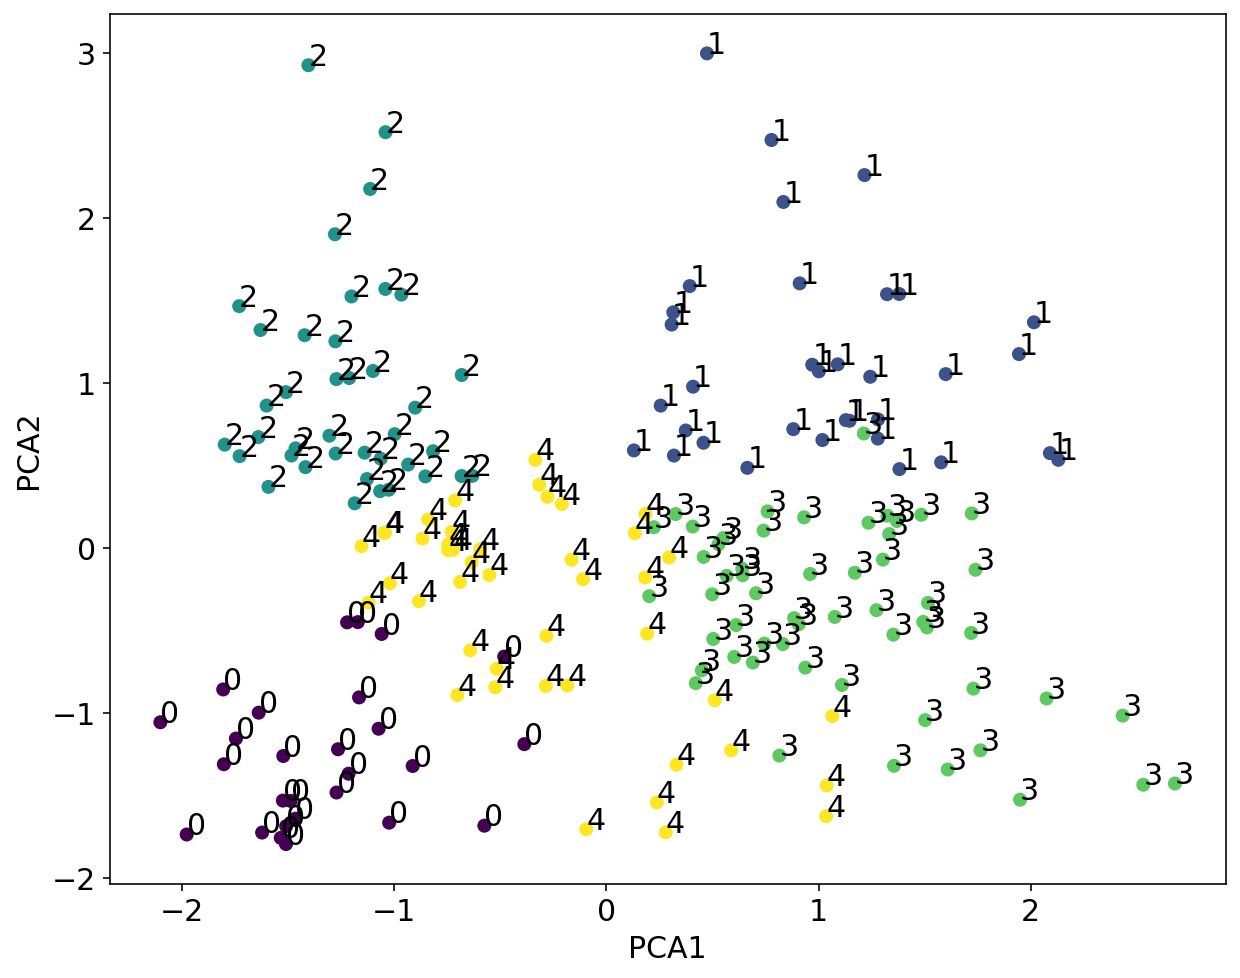

In [28]:
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(df)
plt.figure(figsize=(10,8))
plt.scatter(X_pca2[:,0],X_pca2[:,1], c=y_kmeans)
plt.xlabel('PCA1')
plt.ylabel('PCA2')

for n in range(df.shape[0]):
    plt.text(X_pca2[:,0][n], X_pca2[:,1][n], y_kmeans[n])

## (연습) 클러스터 수가 3, 4, 5, 6 일때의 산포도를 비교하시오
- PCA(2) 공간에서 산포도를 그린다

In [67]:
# (풀이)



## 임의의 특성 공간에서 산포도 그리기

- Age, Annual Income (k$) 특성 축에서 그리기

In [54]:
df.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female',
       'Gender_Male'],
      dtype='object')

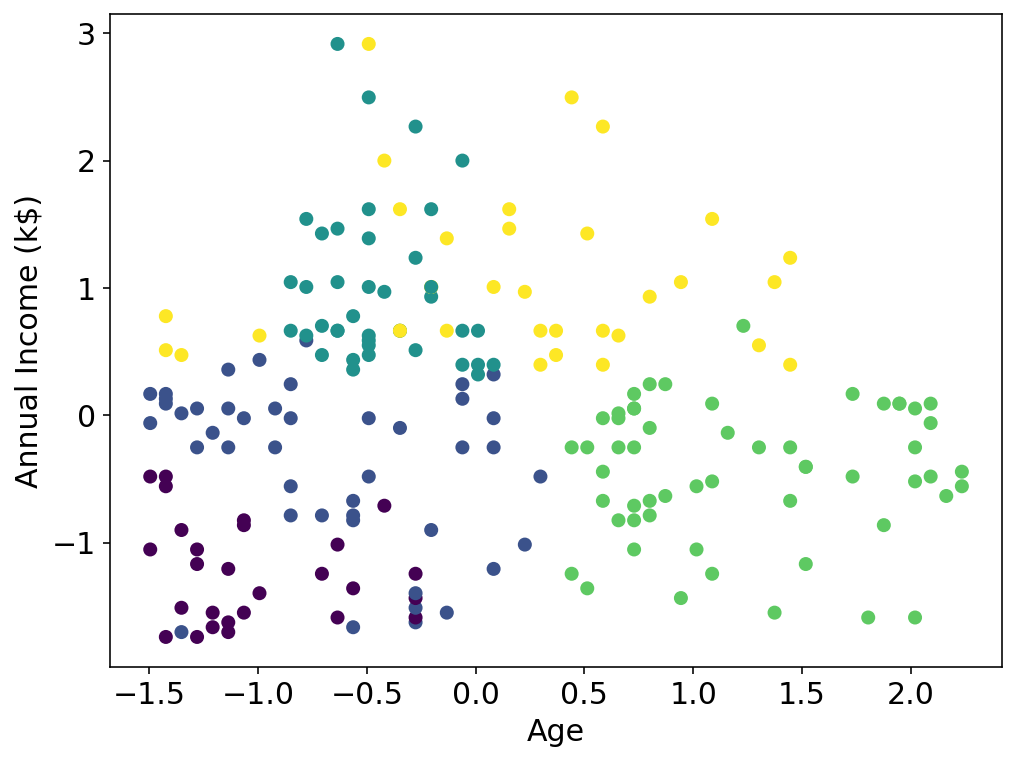

In [55]:
# plt.figure(figsize=(10, 8))
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.scatter(df['Age'], df['Annual Income (k$)'], c=y_kmeans) 

- Spending Score (1-100), Annual Income (k$) 특성 공간에서 그리기

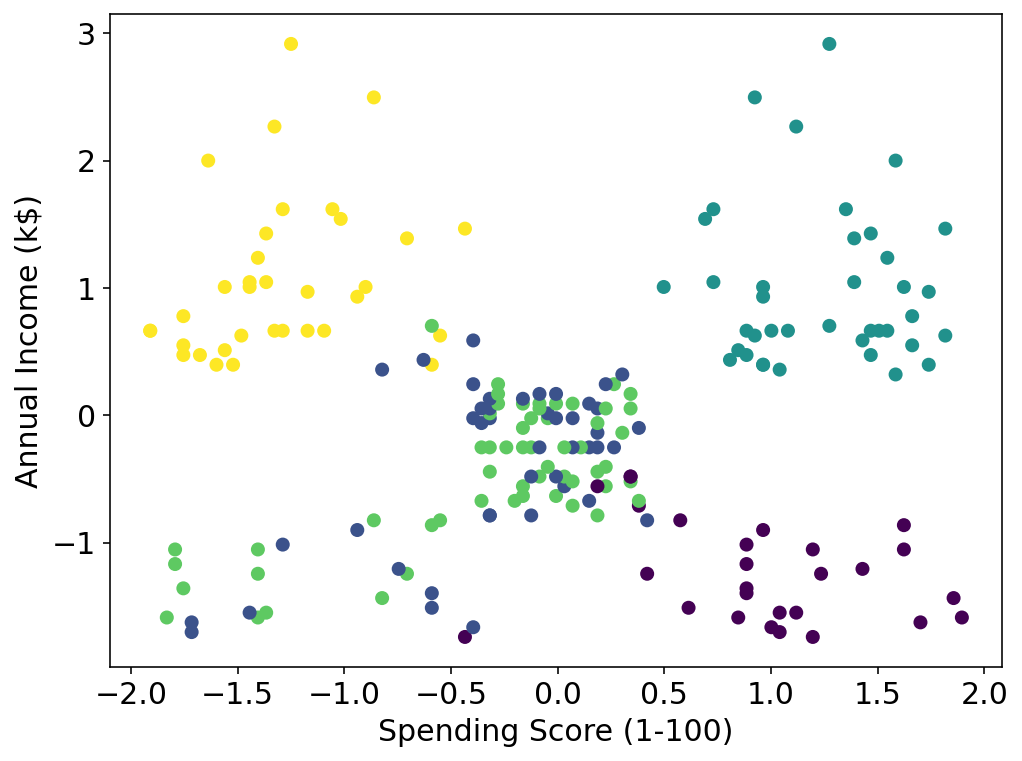

In [56]:
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Annual Income (k$)')
plt.scatter(df['Spending Score (1-100)'], df['Annual Income (k$)'], c=y_kmeans) 

## (연습) 클러스터 수가 3, 4, 5, 6 일때 Spending Score, Annual Income 공간에서 산포도를 그리시오

In [68]:
# (풀이)



# 정답

## (연습) 클러스터 수가 3, 4, 5, 6 일때의 산포도를 비교하시오
- PCA(2) 공간에서 산포도를 그린다

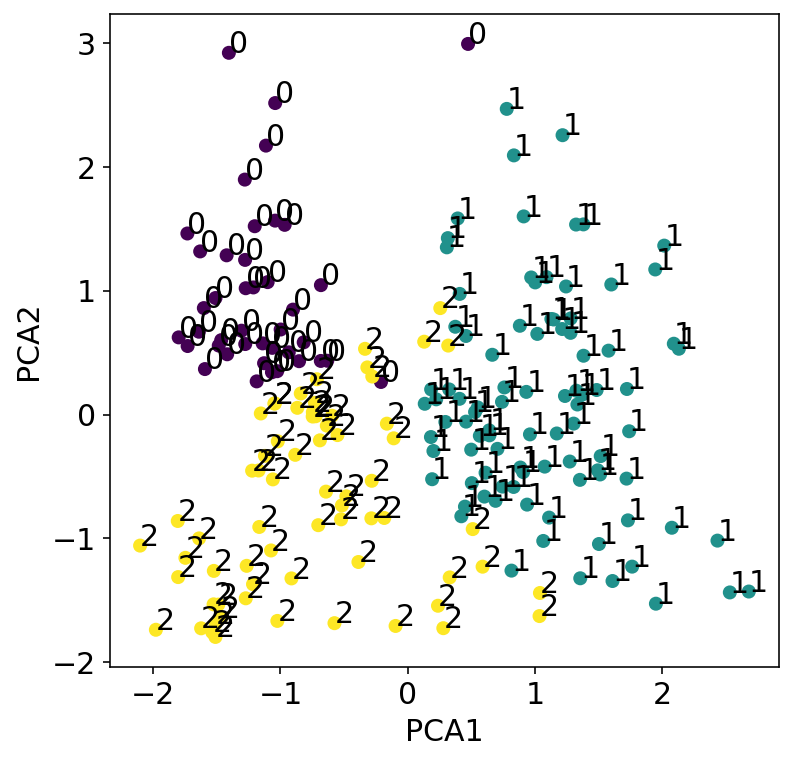

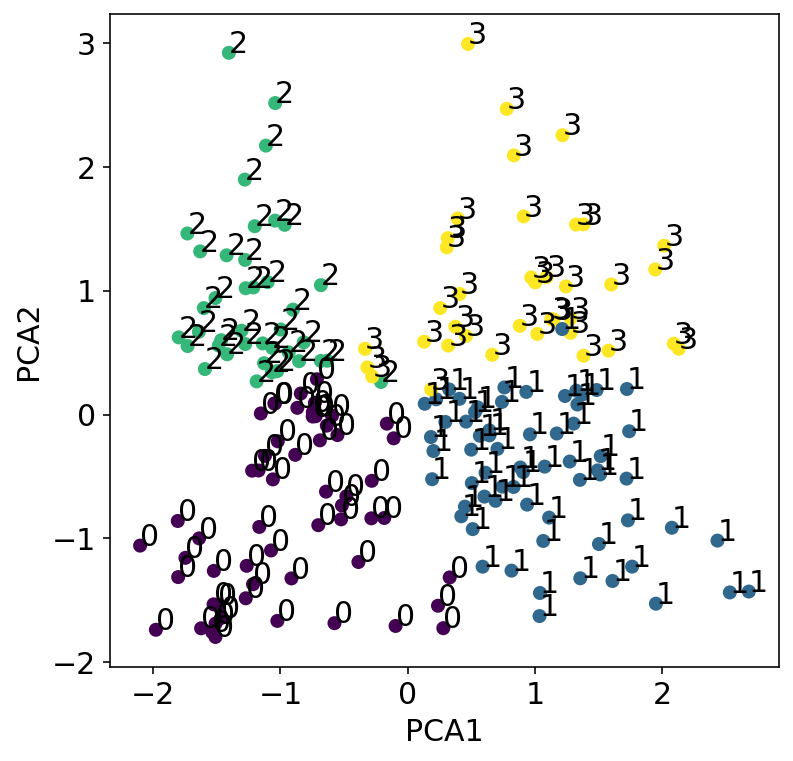

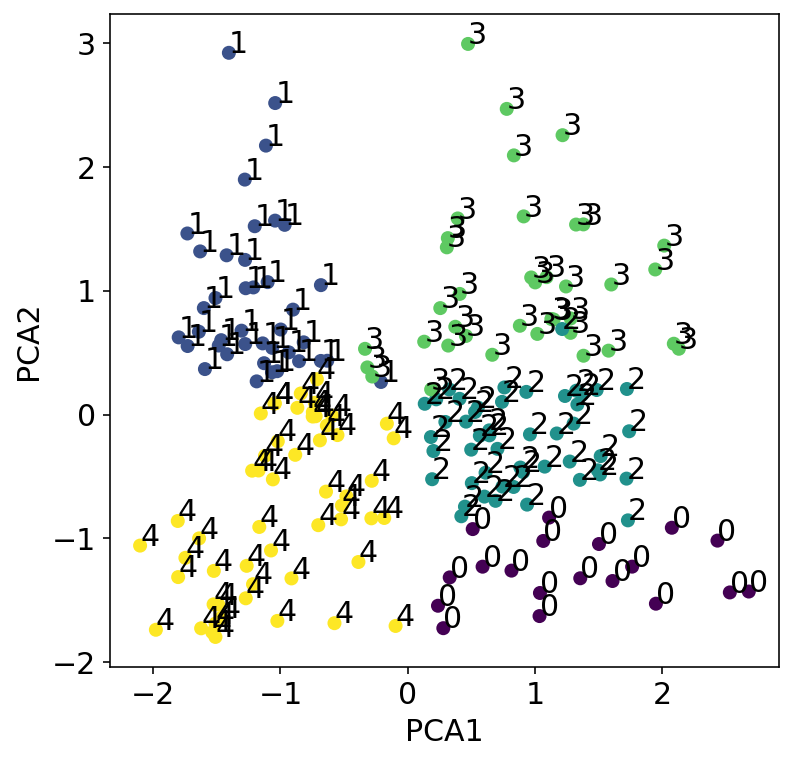

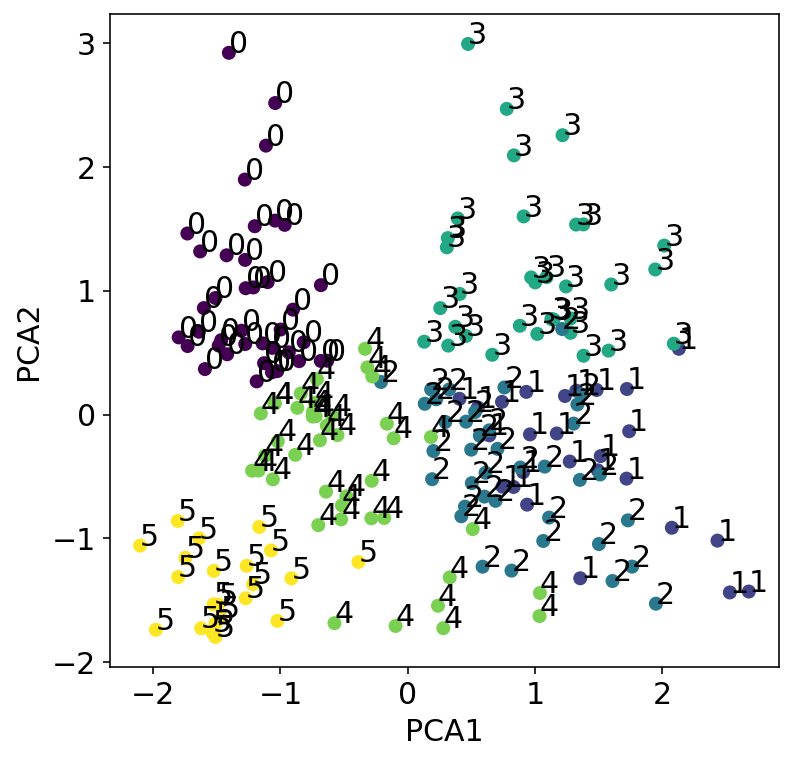

In [34]:
for i in range(3,7):
    kmeans = KMeans(n_clusters = i)
    y_kmeans = kmeans.fit_predict(df)
    plt.figure(figsize=(6,6))
    plt.scatter(X_pca2[:,0],X_pca2[:,1], c=y_kmeans)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')

    for n in range(df.shape[0]):
        plt.text(X_pca2[:,0][n], X_pca2[:,1][n], y_kmeans[n])
    plt.show()

## (연습) 클러스터 수가 3, 4, 5, 6 일때 Spending Score, Annual Income 공간에서 산포도를 그리시오

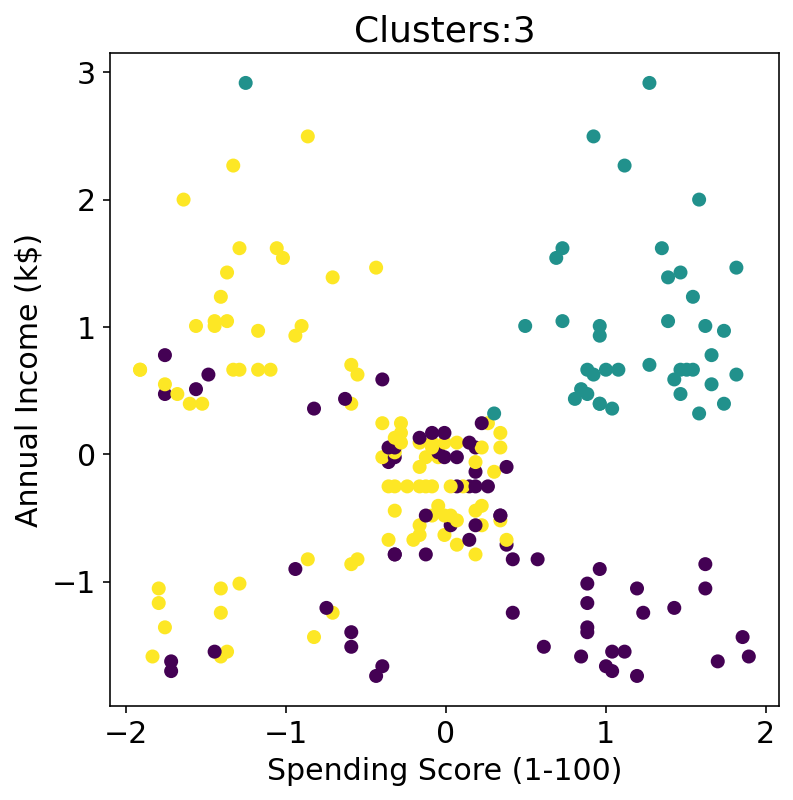

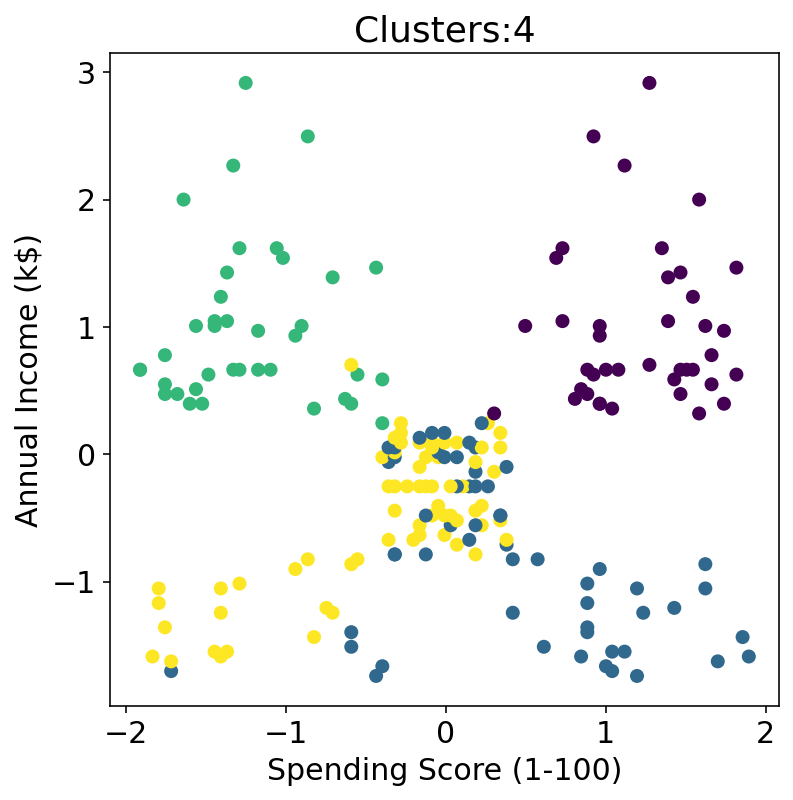

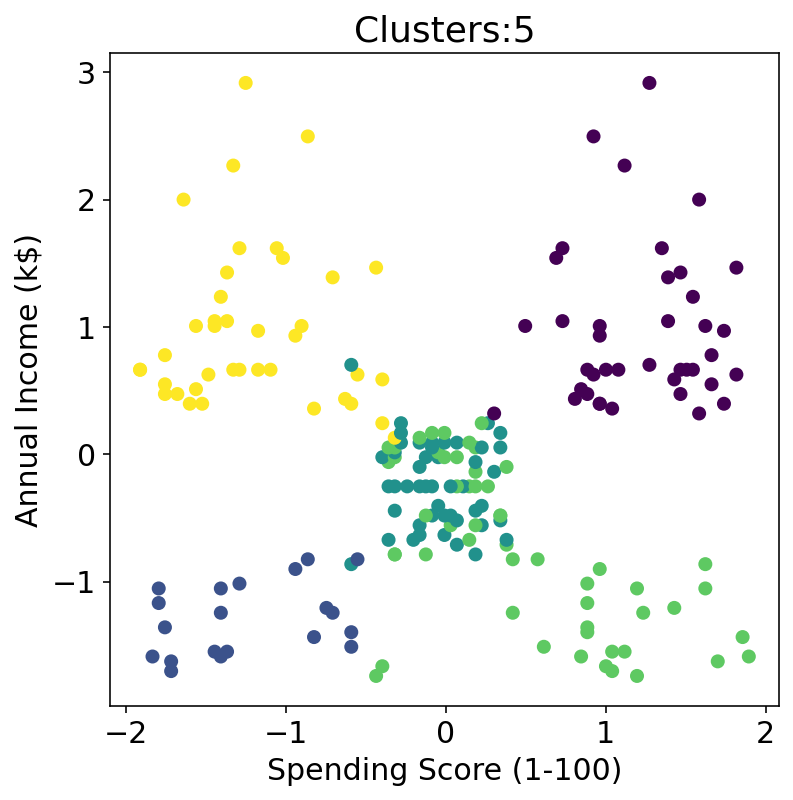

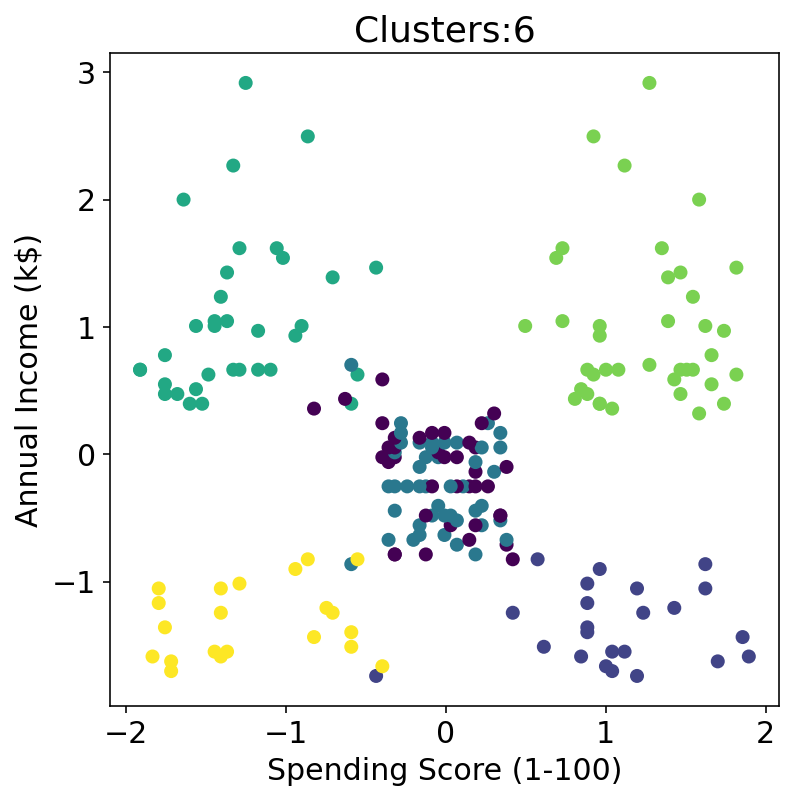

In [66]:
for i in range(3,7):
    kmeans = KMeans(n_clusters = i)
    y_kmeans = kmeans.fit_predict(df)
    plt.figure(figsize=(6,6))
    plt.xlabel('Spending Score (1-100)')
    plt.ylabel('Annual Income (k$)')
    plt.scatter(df['Spending Score (1-100)'], 
                df['Annual Income (k$)'], c=y_kmeans) 
    plt.title('Clusters:'+str(i))
    plt.show()